In [ ]:
figure_base_dir = 

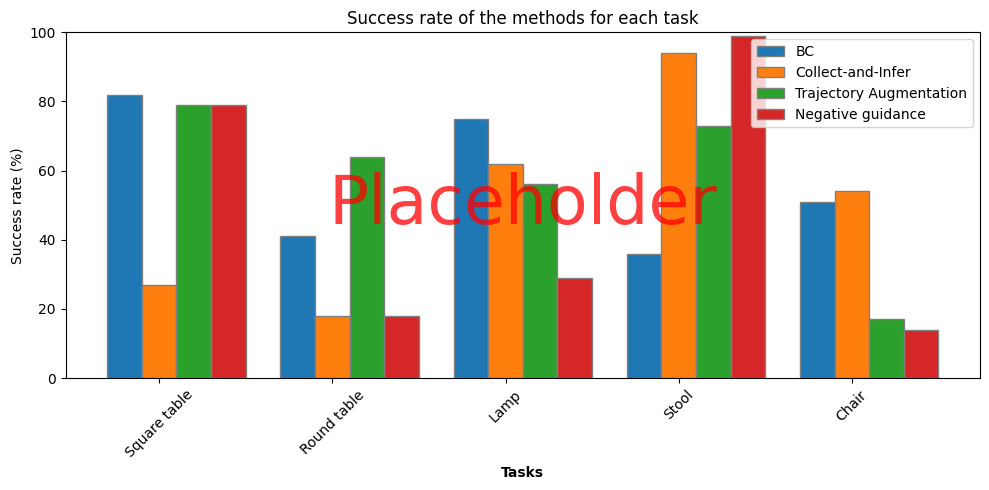

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Data
tasks = ["Square table", "Round table", "Lamp", "Stool", "Chair"]
methods = ["BC", "Collect-and-Infer", "Trajectory Augmentation", "Negative guidance"]
# Generating random data for the methods within each task
data = np.random.randint(0, 100, size=(len(tasks), len(methods)))

fig, ax = plt.subplots(figsize=(10, 5))

# Set position of bar on X axis
barWidth = 0.2
r1 = np.arange(len(data))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Make the plot
ax.bar(
    r1,
    data[:, 0],
    width=barWidth,
    edgecolor="grey",
    label="BC",
)
ax.bar(
    r2,
    data[:, 1],
    width=barWidth,
    edgecolor="grey",
    label="Collect-and-Infer",
)
ax.bar(
    r3,
    data[:, 2],
    width=barWidth,
    edgecolor="grey",
    label="Trajectory Augmentation",
)
ax.bar(
    r4,
    data[:, 3],
    width=barWidth,
    edgecolor="grey",
    label="Negative guidance",
)

# Add xticks on the middle of the group bars
ax.set_xlabel("Tasks", fontweight="bold")
ax.set_xticks([r + barWidth for r in range(len(data))])
ax.set_xticklabels(tasks)
ax.set_ylabel("Success rate (%)")
ax.set_ylim(0, 100)

# Adding the "Placeholder" label
plt.text(
    0.5,
    0.5,
    "Placeholder",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
    color="red",
    fontsize=48,
    alpha=0.75,
)


# Create legend & Show graphic
ax.legend()
plt.xticks(rotation=45)
plt.title("Success rate of the methods for each task")
plt.tight_layout()
plt.savefig("success_rate.pdf")
plt.show()